## Keras-ImageDataGenerator

## 『本次練習內容』
#### 學習使用Keras-ImageDataGenerator 與 Imgaug 做圖像增強

## 『本次練習目的』
  #### 熟悉Image Augmentation的實作方法
  #### 瞭解如何導入Imgae Augmentation到原本NN架構中

---

## 第一 Part

C:\APP\Ana\envs\tf_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\APP\Ana\envs\tf_gpu\lib\site-packages\keras_preprocessing\image\image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
C:\APP\Ana\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to 

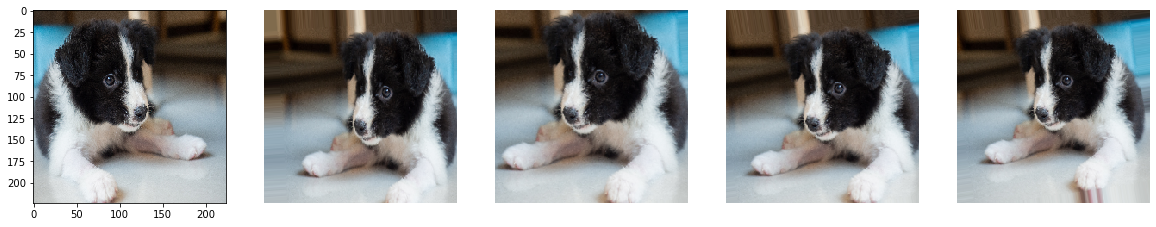

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

##定義使用的Augmentation
img_gen = ImageDataGenerator(featurewise_center=True,
                             featurewise_std_normalization=True,
                             rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_ﬂip=True,
                             vertical_ﬂip=False,
                             dtype=np.ﬂoat32
                            )
width=224
height=224
batch_size=4

img = cv2.imread('Tano.JPG')  
img = cv2.resize(img, (224,224))##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB
img_origin=img.copy()
img= np.array(img, dtype=np.float32)
img_combine=np.array([img,img,img,img],dtype=np.uint8) ##輸入generator要是四維，(224,224,3)變成(4,224,224,3)
batch_gen = img_gen.flow(img_combine, batch_size=4)
assert next(batch_gen).shape==(batch_size, width, height, 3)

plt.figure(figsize=(20,10))
i = 1
for batch in batch_gen:
    plt.subplot(1, 5, 1)
    plt.imshow(img_origin) ##原圖
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0, :, :, :].astype(np.uint8))
    plt.imshow(batch[1, :, :, :].astype(np.uint8))
    plt.imshow(batch[2, :, :, :].astype(np.uint8))
    plt.imshow(batch[3, :, :, :].astype(np.uint8))
    plt.axis('off')
    i += 1
    if i > 4:
        break  # or the generator would loop infinitely

## 示範如何導入ImageDataGenerator到Keras訓練中

NameError: name 'classifier' is not defined

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


classifier=Sequential()

#卷積組合
classifier.add(Convolution2D(filters=32,
                             kernel_size=(3,3),
                             activation='relu',
                             padding='same',
                             input_shape=(64,64,3)))#32,3,3,input_shape=(32,32,3),activation='relu''
classifier.add(BatchNormalization())

'''自己決定MaxPooling2D放在哪裡'''
classifier.add(MaxPooling2D(pool_size=(2,2)))

#卷積組合
classifier.add(Convolution2D(filters=64,
                             kernel_size=(3,3),
                             padding='same',
                             activation='relu',))
classifier.add(BatchNormalization())

classifier.add(MaxPooling2D(pool_size=(2,2)))

#flatten
classifier.add(Flatten())

#FC
classifier.add(Dense(100, activation='relu')) #output_dim=100,activation=relu

#輸出
classifier.add(Dense(2,activation='softmax'))

classifier.summary()

try:
    classifier.load_weights("cifarCnnModel.h5")
    print("載入模型成功!繼續訓練模型")
except:
    print("載入模型失敗!開始訓練一個新模型")
    
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


#Training Generator
train_datagen = ImageDataGenerator(rescale = 2,shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
#Test Generator，只需要Rescale，不需要其他增強
test_datagen = ImageDataGenerator(rescale = 1./255)

#將路徑給Generator，自動產生Label
training_set = train_datagen.flow_from_directory('dataset/training_set',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('dataset/test_set',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'categorical')
    
#訓練
train_history=classifier.fit_generator(training_set,steps_per_epoch = 250,epochs = 20,
                         validation_data = test_set,validation_steps = 250)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0

In [4]:
classifier.save_weights("cifarCnnModel.h5")    
print("Saved model to disk")

Saved model to disk


In [5]:
#預測新照片
from tensorflow.keras.preprocessing import image as image_utils
test_image = image_utils.load_img('dataset/new_images/dog.jpg', target_size=(64, 64))
#test_image = image_utils.load_img('dataset/new_images/cat.jpg', target_size=(64, 64))
test_image = image_utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0) 

result = classifier.predict_on_batch(test_image)
print(result)

tf.Tensor([[0.01246941 0.9875306 ]], shape=(1, 2), dtype=float32)


In [6]:
#預測新照片
from tensorflow.keras.preprocessing import image as image_utils
#test_image = image_utils.load_img('dataset/new_images/dog.jpg', target_size=(64, 64))
test_image = image_utils.load_img('dataset/new_images/cat.jpg', target_size=(64, 64))
test_image = image_utils.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0) 

result = classifier.predict_on_batch(test_image)
print(result)

tf.Tensor([[0.9854683  0.01453163]], shape=(1, 2), dtype=float32)


---

## 練習使用Imgaug

#### 使用單項增強

C:\APP\Ana\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


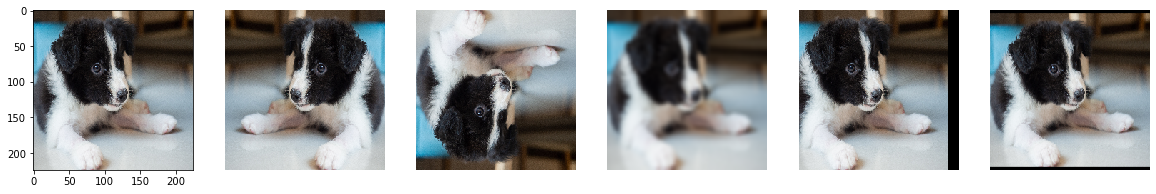

In [7]:
from imgaug import augmenters as iaa
import matplotlib.pyplot as plt
import numpy as np
import cv2

img = cv2.imread('Tano.JPG')  
img = cv2.resize(img, (224,224))##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB
img_origin=img.copy()
img= np.array(img, dtype=np.float32)

images = np.random.randint(0, 255, (5, 224, 224, 3), dtype=np.uint8)##創造一個array size==(5, 224, 224, 3)

flipper = iaa.Fliplr(1.0) #水平翻轉機率==1.0
images[0] = flipper.augment_image(img) 

vflipper = iaa.Flipud(0.4) #垂直翻轉機率40%
images[1] = vflipper.augment_image(img) 

blurer = iaa.GaussianBlur(3.0)
images[2] = blurer.augment_image(img) # 高斯模糊圖像( sigma of 3.0)

translater = iaa.Affine(translate_px={"x": -16}) #向左橫移16個像素
images[3] = translater.augment_image(img) 

scaler = iaa.Affine(scale={"y":(0.8,1.2)}) # 縮放照片，區間(0.8-1.2倍)
images[4] = scaler.augment_image(img)

i=1
plt.figure(figsize=(20,20))
for image in images:
    plt.subplot(1, 6, 1)
    plt.imshow(img_origin.astype(np.uint8))
    plt.subplot(1, 6, i+1)
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    i+=1

---

## 第二Part

#### 打包多種Augmentation

#### 請學員自行練習新增以及改變Augmentation內容
#### 可參考Github: https://github.com/aleju/imgaug

C:\APP\Ana\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


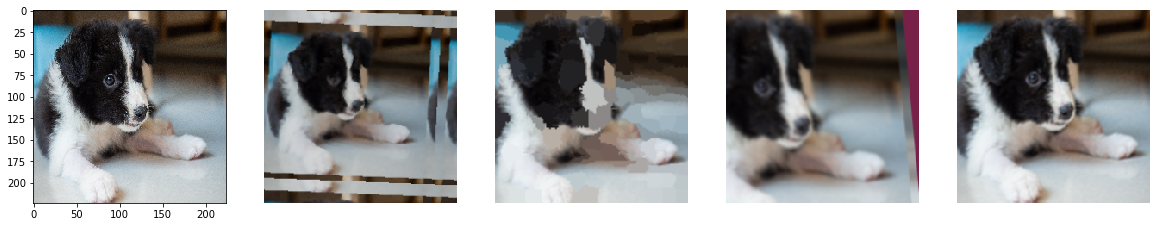

In [8]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline

##輸入照片
img = cv2.imread('Tano.JPG')  
img = cv2.resize(img, (224,224))##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB
img_origin=img.copy()
img= np.array(img, dtype=np.float32 )

img_combine=np.array([img,img,img,img],dtype=np.uint8 ) 

sometimes = lambda aug: iaa.Sometimes(0.5, aug) # Sometimes(0.5, ...) 代表每次都有50%的機率運用不同的Augmentation

##包裝想運用之圖像強化方式
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)),
    iaa.Fliplr(0.4), 
   sometimes(iaa.CropAndPad(
        percent=(-0.05, 0.1),
        pad_mode=ia.ALL,
        pad_cval=(0, 255)
    )),
    sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, 
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, 
        rotate=(-10, 10),
        shear=(-8, 8), 
        order=[0, 1], 
        cval=(0, 255),
        mode=ia.ALL 
    )),
    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
    sometimes(iaa.OneOf([
    iaa.GaussianBlur((0, 3.0)), # blur images 
                    iaa.AverageBlur(k=(1,3)), # blur image using local means with kernel sizes between 1 and 3
                    iaa.MedianBlur(k=(3, 5)), # blur image using local medians with kernel sizes between 3 and 5
                ])),
     sometimes(iaa.Sharpen(alpha=(0, 0.2), lightness=(0.1, 0.4))), # sharpen images
     sometimes(iaa.Emboss(alpha=(0, 0.3), strength=(0, 0.5))), # emboss images
    ],random_order=True)



images_aug = seq.augment_images(img_combine) ## Image Augmentation

##畫出來
i=1
plt.figure(figsize=(20,20))
for image in images_aug:
    plt.subplot(1, 5, 1)
    plt.imshow(img_origin.astype(np.uint8))
    plt.subplot(1, 5, i+1)
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    i+=1

## 包裝自定義Augmentation 與 Imgaug Augmentation

In [9]:
from PIL import Image
import os
import pickle
import numpy as np
import cv2
import glob
import pandas as pd
import time
import random
import imgaug as ia
import imgaug.augmenters as iaa

'''隨機改變亮度'''    
class RandomBrightness(object):
    '''Function to randomly make image brighter or darker
    Parameters
    ----------
    delta: float
        the bound of random.uniform distribution
    '''
    def __init__(self, delta=16):
        assert 0 <= delta <= 255
        self.delta = delta

    def __call__(self, image):
        delta = random.uniform(-self.delta, self.delta)
        if random.randint(0, 1):
            image = image + delta
        image = np.clip(image, 0.0, 255.0)
        return image
    
'''隨機改變對比'''
class RandomContrast(object):
    '''Function to strengthen or weaken the contrast in each image
    Parameters
    ----------
    lower: float
        lower bound of random.uniform distribution
    upper: float
        upper bound of random.uniform distribution
    '''
    def __init__(self, lower=0.5, upper=1.5):
        assert upper >= lower, "contrast upper must be >= lower."
        assert lower >= 0, "contrast lower must be non-negative."
        self.lower = lower
        self.upper = upper

    def __call__(self, image):
        alpha = random.uniform(self.lower, self.upper)
        if random.randint(0, 1):
            image = image * alpha
        image = np.clip(image, 0.0, 255.0)
        return image
    
'''包裝所有Augmentation'''
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image= t(image)
        return image

'''包裝Imgaug'''
class ImgAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image):
        image = self.sequence.augment_image(image)
      
        return image
    
class TrainAugmentations(object):
    def __init__(self):
        #Define imgaug.augmenters Sequential transforms
        sometimes = lambda aug: iaa.Sometimes(0.4, aug) # applies the given augmenter in 50% of all cases

        img_seq = iaa.Sequential([
             sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.03*255), per_channel=0.5)),
             sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=1),),
             sometimes(iaa.Sharpen(alpha=(0, 0.2), lightness=(0.1, 0.4))), # sharpen images
             sometimes(iaa.Emboss(alpha=(0, 0.3), strength=(0, 0.5))), # emboss images
            ],random_order=True)
        
        self.aug_pipeline = Compose([
            RandomBrightness(16), #make image brighter or darker
            RandomContrast(0.9, 1.1), #strengthen or weaken the contrast in each image
            ImgAugSequence(img_seq),
        ])
        

    def __call__(self, image):
        image= self.aug_pipeline(image)
        return image
    
Augmenation=TrainAugmentations()

C:\APP\Ana\envs\tf_gpu\lib\site-packages\imgaug\imgaug.py:182: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


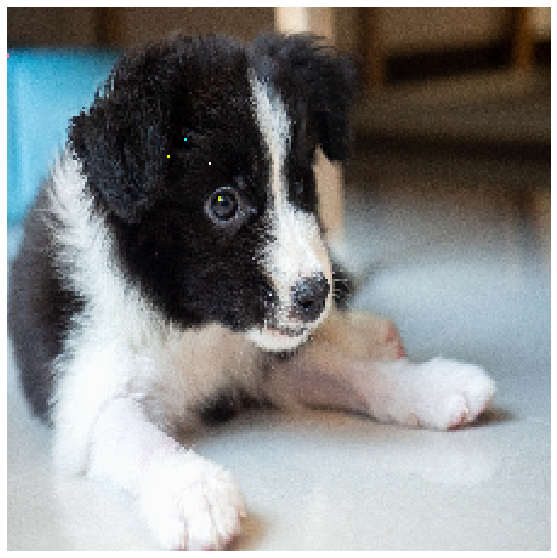

In [43]:
import numpy as np
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
%matplotlib inline

##輸入照片
img = cv2.imread('Tano.JPG')  
img = cv2.resize(img, (224,224))##改變圖片尺寸
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Cv2讀進來是BGR，轉成RGB

output=Augmenation(img) 

##畫出來
plt.figure(figsize=(10,10))
for image in images_aug:
    plt.imshow(output.astype(np.uint8))
    plt.axis('off')


## 鎖住隨機性-主要用在Semantic segmentation中

In [10]:
class MaskAugSequence(object):
    def __init__(self, sequence):
        self.sequence = sequence

    def __call__(self, image, mask):
        sequence = self.sequence.to_deterministic() ##用來關閉隨機性
        image = sequence.augment_image(image)
        mask = sequence.augment_image(mask)
        image,  mask= image.astype(np.float32), mask.astype(np.float32)
        return image,  mask